In [1]:
import pandas as pd
import numpy as np

In [2]:
import os

dataset_path = r".\training_pl_cs_ru_bg_rc1"

ru_file_names = [
    'brexit_ru.txt_file_108', 'brexit_ru.txt_file_112', 'brexit_ru.txt_file_116',
    'brexit_ru.txt_file_1000', 'brexit_ru.txt_file_1001', 'brexit_ru.txt_file_1002',
    'brexit_ru.txt_file_1003', 'brexit_ru.txt_file_1004', 'brexit_ru.txt_file_1005',
]

ENTITY_TYPES = ['PER', 'ORG', 'LOC', 'EVT', 'PRO']

### Задание 1
   - NER - задача нахождения в тексте именованных сущностей. Например, в данной задаче надо найти в тексте сущности вида `PER`, `ORG`, `LOC`, `EVT`, `PRO`. Из общего можно отметить, что это задача на NLU (Natural Language Understanding), а не на генерацию (хотя её и можно решать с помощью генеративных моделей).
   
   - классические методы для решения
       - `fine-tuning` модели типа `BERT` (`BERT` в целом хорошо подходит для многих задач NLU). В таком случае задачу можно рассматривать как потокенную классификацию, т.е. для каждого входного токена будем вешать линейную регрессию на соответсвующий выходной эмбеддинг BERT'а, которая и будет предсказывать, к какому entity принадлежит данный токен. `Fine-tuning` можно осуществлять с помощью `LoRA` или других `PEFT`-методов. Насколько я понимаю, на данный момент SotA решения примерно так и устроены. Из минусов можно отметить необходимость затрачивать ресурсы на дообучение.
       - `prompt engineering` с различными подходами вроде `few-shot` и `chain-of-thought` обучения. В данном случае нужна хорошая генеративная модель, на вход которой подается специально сконструированный промпт, содержащий формулировку задания, пример решения похожих задач и т.д. В отличии от прошлого подхода не требуется никакого дообучения.
    
   - для оценки качества в данной задаче используются метрики:
       - `precision` - показывает, насколько много правильных entity среди предсказанных
       - `recall` - показывает, насколько много из всех правильных entity было предсказано
       - `f1_score` - среднее гармоническое precision'а и recall'а, показывает насколько хорошо модель себя ведет и с точки зрения `precision`'а, и с точки зрения `recall`'а
   -  https://github.com/kulevkirill/test_task/tree/main -- итоговые предсказания модели

### Задание 2
   - Чтение датасета в `pandas.DataFrame`

In [3]:
def read_dataset(file_names=ru_file_names, dataset_path=dataset_path):
    dataset_df = pd.DataFrame(columns=['document_id', 'document_text', 'entity', 'gold_answer'])

    for file_name in file_names:

        annotation = r"annotated\ru"
        text = r"raw\ru"

        file_annotation_name = os.path.join(dataset_path, annotation, file_name + '.out')
        file_text_name = os.path.join(dataset_path, text, file_name + '.txt')

        # reads the file with text
        with open(file_text_name, 'r', encoding="utf8") as file:
            document_id = file.readline().strip()
            text = ''.join(file.readlines()[3:]) # the slice [3:] is to skip 1) the language id, 2) the date and 3) the ref 

        # reads the annotation file
        with open(file_annotation_name, 'r', encoding="utf8") as file:

            entity_dict = {entity: [] for entity in ENTITY_TYPES}
            for line in file.readlines()[1:]:
                in_text_form, standart_form, entity_type, entity_name = line.strip().split('\t')
                entity_dict[entity_type] += [standart_form]

        # creates dataset for new file
        dataset = {'document_id': [], 'document_text': [], 'entity': [], 'gold_answer': []}

        for entity_type, entity_list in entity_dict.items():
            dataset['document_id'].append(document_id)
            dataset['document_text'].append(text)
            dataset['entity'].append(entity_type)
            dataset['gold_answer'].append(','.join(entity_list))

        dataset_df = pd.concat([dataset_df, pd.DataFrame(dataset)], ignore_index=True)
    
    return dataset_df

In [4]:
dataset_df = read_dataset()
dataset_df.head(6)

,document_id,document_text,entity,gold_answer
0,ru-108,"Стало известно, кто сменил Бориса Джонсона на ...",PER,"Борис Джонсон,Джереми Хант,Джереми Хант,Мэй,Те..."
1,ru-108,"Стало известно, кто сменил Бориса Джонсона на ...",ORG,"ЕС,Евросоюз,Кабмин,МИД Великобритании,МИД"
2,ru-108,"Стало известно, кто сменил Бориса Джонсона на ...",LOC,"Британия,Великобритания"
3,ru-108,"Стало известно, кто сменил Бориса Джонсона на ...",EVT,Brexit (Брексит)
4,ru-108,"Стало известно, кто сменил Бориса Джонсона на ...",PRO,"Times,Twitter,Ракурс"
5,ru-112,В Англии прошла тайная встреча советника Трамп...,PER,"Болтон,Болтон,Джон Болтон,Дональд Трамп,Марк С..."


### Задание 3
   - создание промптов для LLM 
   - решил попробовать несколько подходов, чтобы добиться как можно лучшего результа
       - (1) генерировать отдельный промпт для каждой пары (документ, entity) (т.е. по 5 на каждый документ). В промпте описывается задача и дается пример решения. Решил попробовать данный подход, чтобы узнать, проще ли модели будет выделять только определенный entity, а не пытаться определить сразу все. -- (см. фукцию `create_prompt_per_entity`)
       - (2) генерировать отдельный промпт для каждой пары (документ, entity), но для каждого entity указывать больше индивидуальный подсказок (например, для entity EVT я указал, что событие должно быть досточно важным, чтобы засчитываться как EVT (Brexit считается за EVT, а собрание депутатов партии не считается) и т.п. для других entity) -- (см. фукцию `create_prompt_per_entity_more_diverse`)
       - (3) генерировать промпт для каждого документа так, чтобы он указывал в ответе сразу все entity. Подсказки из прошлого пункта также добавил в промпт. -- (см. фукцию `create_prompt_per_document`)

In [5]:
def create_prompt_per_entity(entity):
    '''Generates special prompt based on the given entity.
    '''
    entity_to_russian_dict = {'PER': 'персона', 'ORG': 'организация', 'EVT': 'событие', 'PRO': 'продукт', 'LOC': 'локация'}
    return f'''Задача: Получив на вход текст, выдели все возможные именованные сущности вида {entity} ({entity_to_russian_dict[entity]}) и приведи каждую сущность к стандартному виду. Одни и те же сущности могут повторяться несколько раз, важно выписать каждую сущность столько раз, сколько она упоминается в тексте.
Ответ выведи в виде строки так, чтобы все именованные сущности были разделены запятой. Например, на текст "Тереза Мэй рассчитывает усидеть в седле до завершения процедуры, однако противники Мэй навяжут ей серьезный бой. Фаворит - бывший министр иностранных дел Британии Борис Джонсон" нужно ответить "Тереза Мэй, Мэй, Борис Джонсон"

Текст:
'''

def create_prompt_per_entity_diverse(entity):
    '''Generates special prompt based on the given entity and adds an individual example of right answer for each entity.
    '''
    entity_to_example = {
        'PER': '''на текст "Тереза Мэй рассчитывает усидеть в седле до завершения процедуры, однако противники Мэй навяжут ей серьезный бой. Фаворит - бывший министр иностранных дел Британии Борис Джонсон" нужно ответить "Тереза Мэй,Мэй,Борис Джонсон". Важно, что ответ надо приводить к стандартной форме, то есть ответ "Трампа,Джона Болтона" не верный, а "Трамп,Джон Болтон" верный.''',
        'ORG': '''на текст "Министр иностранных дел Великобритании Борис Джонсон уходит в отставку не из-за позиции правительства Великобритании по выходу из Евросоюза" нужно ответить "правительство Великобритании,Евросоюз". Важно отметить, что такие слова как "Даунинг-стрит" не надо давать в качестве ответа.''',
        'EVT': '''на текст "Стратегия по «Брекситу» была согласована на встрече депутатов партии тори 6 июля, Brexit состоится независимо от позиции ЕС" нужно оветить "Брексит,Brexit". Важно обратить внимение, что событие должно быть достаточно важным, чтобы попасть в ответ: например, "встречу депутатов партии тори" записывать в ответ не надо, а "Брексит" надо.''',
        'PRO': '''на текст "Согласно сообщению в Twitter газета Times передает, что стратегия Brexit находится в разработке" надо ответить "Twitter,Times".''',
        'LOC': '''на текст "Позиция Даунинг-стрит по данному вопросу такова, что Великобритании пора покидать ЕС, хотя в Лондоне это и не одобряют" надо ответить "Даунинг-стрит,Великобритания,Лондон".''',
    }
    
    entity_to_russian_dict = {'PER': 'персона', 'ORG': 'организация', 'EVT': 'событие', 'PRO': 'продукт', 'LOC': 'локация'}
    return f'''Задача: Получив на вход текст, выдели все возможные именованные сущности вида {entity} ({entity_to_russian_dict[entity]}) и приведи каждую сущность к стандартному виду. Одни и те же сущности могут повторяться несколько раз, важно выписать каждую сущность столько раз, сколько она упоминается в тексте.
Ответ выведи в виде строки так, чтобы все именованные сущности были разделены запятой. 
Например, {entity_to_example[entity]}

Текст:
'''


def generate_prompt(create_prompt, dataset_df):
    '''Takes the fucntion for creating prompt and places the generated prompt before the text from dataset row.
    '''
    prompt = create_prompt(dataset_df.entity)
    text = dataset_df.document_text
    return prompt + text


def create_prompt_per_document(dataset_df):
    '''Generates prompt only based on the text (no induvidual prompts for different entities)
    '''
    return '''Задача: Получив на вход текст, выдели все возможные именованные сущности вида PER (персона), ORG (организация), EVT (событие), PRO (продукт), LOC (локация). Для каждой типа выведи строку со всеми встрченными сущностями данного типа, при этом важно выписать каждую сущность столько раз, сколько она встречается в тексте.
    Например, на текст "Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit, однако противники Мэй, поддерживающие Евросоюз, навяжут ей серьезный бой. Из сообщения в Twitter следует, что фаворит - бывший глава МИДа Британии Борис Джонсон, хотя Times со ссылкой на источники в Великобритании и не подтверждает этого." надо вывести ответ в виде:
    PER|Тереза Мэй,Мэй,Борис Джонсон
    ORG|Евросоюз,МИД
    LOC|Великобритания
    EVT|Brexit
    PRO|Twitter,Times
    
    Важные замечания по заданию: 1) "Даунинг-стрит" надо отностить к LOC, а не к ORG, 2) Событие должно быть достаточно важным, чтоб попасть в EVT, напирмер "Brexit" подходит, а "встреча депутатов партии тори" нет, 3) Слова надо приводить в стандартную форму, например надо писать не "Трампа,Джона Болтона", а "Трамп,Джон Болтон."
    Текст:
    ''' + dataset_df.document_text

### Примеры промптов всех трех типов

In [6]:
# AN EXAMPLE OF PROMPT PER ENTITY
n = 0
print(generate_prompt(create_prompt_per_entity, dataset_df.iloc[n]))

Задача: Получив на вход текст, выдели все возможные именованные сущности вида PER (персона) и приведи каждую сущность к стандартному виду. Одни и те же сущности могут повторяться несколько раз, важно выписать каждую сущность столько раз, сколько она упоминается в тексте.
Ответ выведи в виде строки так, чтобы все именованные сущности были разделены запятой. Например, на текст "Тереза Мэй рассчитывает усидеть в седле до завершения процедуры, однако противники Мэй навяжут ей серьезный бой. Фаворит - бывший министр иностранных дел Британии Борис Джонсон" нужно ответить "Тереза Мэй, Мэй, Борис Джонсон"

Текст:
Стало известно, кто сменил Бориса Джонсона на посту главы МИД Великобритании

Бориса Джонсона на посту главы МИД Великобритании сменил Джереми Хант экс-министр здравоохранения страны. Об этом сообщила канцелярия премьер-министра Британии в Twitter. Королева была рада утвердить назначение Джереми Ханта, говорится в сообщении. Напомним, сегодня глава МИД Великобритании . Это произошло н

In [7]:
#AN EXAMPLE OF PROMPT PER ENTITY BUT WITH ADDITIONAL INDIVIDUAL INFORMATION
n = 0
print(generate_prompt(create_prompt_per_entity_diverse, dataset_df.iloc[n]))

Задача: Получив на вход текст, выдели все возможные именованные сущности вида PER (персона) и приведи каждую сущность к стандартному виду. Одни и те же сущности могут повторяться несколько раз, важно выписать каждую сущность столько раз, сколько она упоминается в тексте.
Ответ выведи в виде строки так, чтобы все именованные сущности были разделены запятой. 
Например, на текст "Тереза Мэй рассчитывает усидеть в седле до завершения процедуры, однако противники Мэй навяжут ей серьезный бой. Фаворит - бывший министр иностранных дел Британии Борис Джонсон" нужно ответить "Тереза Мэй,Мэй,Борис Джонсон". Важно, что ответ надо приводить к стандартной форме, то есть ответ "Трампа,Джона Болтона" не верный, а "Трамп,Джон Болтон" верный.

Текст:
Стало известно, кто сменил Бориса Джонсона на посту главы МИД Великобритании

Бориса Джонсона на посту главы МИД Великобритании сменил Джереми Хант экс-министр здравоохранения страны. Об этом сообщила канцелярия премьер-министра Британии в Twitter. Королев

In [8]:
#AN EXAMPLE OF PROMPT PER DOCUMENT THAT ASKS FOR ALL THE ENTITIES AT THE SAME TIME
n = 0 #0, 5, 10, 15, 20, 25, 30, 35, 40
print(create_prompt_per_document(dataset_df.iloc[n]))

Задача: Получив на вход текст, выдели все возможные именованные сущности вида PER (персона), ORG (организация), EVT (событие), PRO (продукт), LOC (локация). Для каждой типа выведи строку со всеми встрченными сущностями данного типа, при этом важно выписать каждую сущность столько раз, сколько она встречается в тексте.
    Например, на текст "Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit, однако противники Мэй, поддерживающие Евросоюз, навяжут ей серьезный бой. Из сообщения в Twitter следует, что фаворит - бывший глава МИДа Британии Борис Джонсон, хотя Times со ссылкой на источники в Великобритании и не подтверждает этого." надо вывести ответ в виде:
    PER|Тереза Мэй,Мэй,Борис Джонсон
    ORG|Евросоюз,МИД
    LOC|Великобритания
    EVT|Brexit
    PRO|Twitter,Times
    
    Важные замечания по заданию: 1) "Даунинг-стрит" надо отностить к LOC, а не к ORG, 2) Событие должно быть достаточно важным, чтоб попасть в EVT, напирмер "Brexit" подходит, а "встреча депутат

### Задание 4
   - внес ответы GigaChat в DataFrame

In [9]:
pred = [None] * 45

# document 1
pred[0] = 'Борис Джонсон, Джереми Хант, премьер-министра Британии, королева, Джереми Хант, глава МИД Великобритании, Тереза Мэй, Мэй, Борис Джонсон'
pred[1] = 'МИД Великобритании, правительство, Евросоюз, Кабмин, Times'
pred[2] = 'Великобритания'
pred[3] = 'Brexit'
pred[4] = 'Twitter'

# document 2
pred[5] = 'Джон Болтон, Дональд Трамп, Марк Седвилл, Тереза Мэй'
pred[6] = 'Консервативная партия, Европейская исследовательская группа, The Telegraph, The Sunday Telegraph'
pred[7] = 'Англия, Великобритания, Лондон'
pred[8] = 'тайная встреча, визит Дональда Трампа'
pred[9] = 'The Telegraph, The Sunday Telegraph'

# document 3
pred[10] = 'Джон Болтон, Дональд Трамп, Марк Седвилл'
pred[11] = 'Европейская исследовательская группа, The Telegraph'
pred[12] = 'Великобритания, Англия, Лондон'
pred[13] = 'встреча с депутатами-евроскептиками, референдум о выходе Англии из Европейского союза'
pred[14] = 'The Telegraph'

# document 4
pred[15] = 'Борис Джонсон, Дэвид Дэвис, Стив Бейкер, Тереза Мэй'
pred[16] = 'Министерство иностранных дел Великобритании, Кабинет министров Великобритании, британский парламент'
pred[17] = 'Великобритания'
pred[18] = 'Отставка Бориса Джонсона, отставка Дэвида Дэвиса, отставка Стива Бейкера'
pred[19] = 'The Guardian'

# document 5
pred[20] = 'Борис Джонсон, Тереза Мэй'
pred[21] = 'Министерство иностранных дел Великобритании, Евросоюз'
pred[22] = 'Великобритания'
pred[23] = 'Отставка Бориса Джонсона, Brexit'
pred[24] = 'Associated Press'

# document 6
pred[25] = 'Тереза Мей, Борис Джонсон, Дэвид Дэвис'
pred[26] = 'ЕС'
pred[27] = 'Великобритания'
pred[28] = 'Отставка Бориса Джонсона, Brexit'
pred[29] = 'Брекзит'

# document 7
pred[30] = 'Борис Джонсон, Тереза Мэй, Дэвид Дэвис'
pred[31] = 'Министерство иностранных дел Великобритании, Даунинг-стрит'
pred[32] = 'Великобритания'
pred[33] = 'Отставка Бориса Джонсона, Brexit'
pred[34] = 'Рейтер'

# document 8
pred[35] = 'Борис Джонсон, Тереза Мэй, Дэвид Дэвис'
pred[36] = 'Министерство иностранных дел Великобритании, Консервативная партия'
pred[37] = 'Великобритания'
pred[38] = 'Отставка Бориса Джонсона, Brexit'
pred[39] = 'ТАСС'

# document 9
pred[40] = 'Тереза Мэй, Борис Джонсон, Дэвид Дэвис'
pred[41] = 'Министерство иностранных дел Великобритании, Консервативная партия'
pred[42] = 'Великобритания'
pred[43] = 'Отставка Бориса Джонсона, Brexit'
pred[44] = 'The Guardian'

for i, val in enumerate(pred):
    pred[i] = ','.join(val.split(', '))
    
#dataset_df['pred_answer'] = pd.Series(pred)

In [10]:
pred_diverse = [None] * 45

# document 1
pred_diverse[0] = 'Борис Джонсон,Джереми Хант,Королева,Джереми Ханта,Тереза Мэй'
pred_diverse[1] = 'Кабмин'
pred_diverse[2] = 'Великобритания'
pred_diverse[3] = 'Brexit (Брексит)'
pred_diverse[4] = 'Twitter'

# document 2
pred_diverse[5] = 'Джон Болтон,Дональд Трамп,Марк Седвилл,Тереза Мэй'
pred_diverse[6] = 'Консервативная партия,Европейская исследовательская группа,The Telegraph,The Sunday Telegraph'
pred_diverse[7] = 'Англия,Лондон'
pred_diverse[8] = 'Brexit'
pred_diverse[9] = 'The Telegraph,The Sunday Telegraph'

# document 3
pred_diverse[10] = 'Джон Болтон,Дональд Трамп,Марк Седвилл'
pred_diverse[11] = 'Европейская исследовательская группа,The Telegraph'
pred_diverse[12] = 'Англия,Лондон'
pred_diverse[13] = 'Brexit'
pred_diverse[14] = 'The Telegraph'

# document 4
pred_diverse[15] = 'Борис Джонсон,Дэвид Дэвис,Стив Бейкер,Тереза Мэй'
pred_diverse[16] = 'ЕС,The Guardian,британский парламент'
pred_diverse[17] = 'Великобритания'
pred_diverse[18] = 'Brexit'
pred_diverse[19] = 'The Guardian'

# document 5
pred_diverse[20] = 'Борис Джонсон,Тереза Мэй'
pred_diverse[21] = 'Associated Press,Евросоюз'
pred_diverse[22] = 'Великобритания'
pred_diverse[23] = 'Brexit'
pred_diverse[24] = 'Associated Press'

# document 6
pred_diverse[25] = 'Тереза Мей,Борис Джонсон,Дэвид Дэвис'
pred_diverse[26] = 'правительство Великобритании,ЕС'
pred_diverse[27] = 'Великобритания'
pred_diverse[28] = 'Brexit'
pred_diverse[29] = 'Брекзит'

# document 7
pred_diverse[30] = 'Борис Джонсон,Тереза Мэй,Дэвид Дэвис'
pred_diverse[31] = 'Рейтер,Даунинг-Стрит,правительство Великобритании,Евросоюз'
pred_diverse[32] = 'Даунинг-стрит,Великобритания'
pred_diverse[33] = 'Brexit'
pred_diverse[34] = 'Рейтер'

# document 8
pred_diverse[35] = 'Борис Джонсон,Тереза Мэй,Дэвид Дэвис'
pred_diverse[36] = 'Правительство Великобритании,Евросоюз'
pred_diverse[37] = 'Великобритания,Лондон'
pred_diverse[38] = 'Brexit'
pred_diverse[39] = 'TASS'

# document 9
pred_diverse[40] = 'Тереза Мэй,Борис Джонсон,Дэвид Дэвис'
pred_diverse[41] = 'Правительство Великобритании,Евросоюз'
pred_diverse[42] = 'Великобритания'
pred_diverse[43] = 'Brexit'
pred_diverse[44] = 'Twitter,Times'

#dataset_df['pred_answer'] = pd.Series(pred_diverse)

In [11]:
pred_per_document = [None] * 45

# document 1
pred_per_document[0] = 'Борис Джонсон,Джереми Хант,Тереза Мэй'
pred_per_document[1] = 'МИД Великобритании,ЕС,Кабмин'
pred_per_document[2] = 'Великобритания'
pred_per_document[3] = 'Brexit'
pred_per_document[4] = 'Twitter,Times'

# document 2
pred_per_document[5] = 'Джон Болтон,Трамп,Марк Седвилл,Тереза Мэй'
pred_per_document[6] = 'Консервативная партия,Европейская исследовательская группа,ЕС,Кабмин'
pred_per_document[7] = 'Англия,Лондон,Великобритания'
pred_per_document[8] = 'Brexit'
pred_per_document[9] = 'The Telegraph,The Sunday Telegraph'

# document 3
pred_per_document[10] = 'Джон Болтон,Дональд Трамп,Марк Седвилл'
pred_per_document[11] = 'Европейская исследовательская группа,ЕС'
pred_per_document[12] = 'Англия,Великобритания,Лондон'
pred_per_document[13] = 'Brexit'
pred_per_document[14] = 'The Telegraph'

# document 4
pred_per_document[15] = 'Борис Джонсон,Дэвид Дэвис,Стив Бейкер,Тереза Мэй'
pred_per_document[16] = 'ЕС,парламент Великобритании'
pred_per_document[17] = 'Великобритания'
pred_per_document[18] = 'Brexit'
pred_per_document[19] = 'Подробности.ua,The Guardian,УНН'

# document 5
pred_per_document[20] = 'Борис Джонсон,Тереза Мэй'
pred_per_document[21] = 'ЕС'
pred_per_document[22] = 'Великобритания'
pred_per_document[23] = 'Brexit'
pred_per_document[24] = 'Associated Press'

# document 6
pred_per_document[25] = 'Тереза Мей,Борис Джонсон,Дэвид Дэвис'
pred_per_document[26] = 'ЕС'
pred_per_document[27] = 'Великобритания'
pred_per_document[28] = 'Brexit'
pred_per_document[29] = ''

# document 7
pred_per_document[30] = 'Борис Джонсон,Тереза Мэй,Дэвид Дэвис'
pred_per_document[31] = 'ЕС'
pred_per_document[32] = 'Великобритания,Даунинг-Стрит'
pred_per_document[33] = 'Brexit'
pred_per_document[34] = 'Рейтер'

# document 8
pred_per_document[35] = 'Борис Джонсон,Тереза Мэй,Дэвид Дэвис'
pred_per_document[36] = 'ЕС,Консервативная партия'
pred_per_document[37] = 'Великобритания,Германия,Польша,Западные Балканы'
pred_per_document[38] = 'Brexit'
pred_per_document[39] = 'ТАСС'

# document 9
pred_per_document[40] = 'Тереза Мэй,Борис Джонсон,Дэвид Дэвис'
pred_per_document[41] = 'правительство Великобритании,ЕС'
pred_per_document[42] = 'Великобритания'
pred_per_document[43] = 'Brexit'
pred_per_document[44] = 'Twitter,Times'

#dataset_df['pred_answer'] = pd.Series(pred_per_document)

### Задание 5
   - реализовал алгоритм для подсчёта метрик (`precision`, `recall` и `f1_score`) 
   - написал юнит-тесты для проверки правильности работы функции
   - в данном случае я не вижу возможности для ускорения работы функции через векторную реализацию, так как приходится работать со строками, а не с векторами и матрицами из чисел, для которых можно было бы использовать векторную оптимизацию
   - `замечание по подсчету метрик`: матчить предсказания с верными метриками можно немного по-разному. Для просты я засчитывал entity только если было полное совпадение. Можно также засчитывать несколько верных вариантов для одного ground_truth объекта (например, "Министерство иностранных дел" и "Министерство иностранных дел Великобритании" можно считать одинаково правильными)

In [12]:
 from collections import Counter

def score_fn(gold, pred):
    gold_list = gold.split(',')
    pred_list = pred.split(',')
    
    num_pred = len(pred_list)
    num_gold = len(gold_list)
    
    num_matched = 0
    
    # counter is used to keep track of duplicates
    gold_counter = Counter(gold_list)
    for pred in pred_list:
        if pred in gold_counter and gold_counter[pred] > 0:
            gold_counter[pred] -= 1
            num_matched += 1
    
    return num_matched / num_pred, num_matched / num_gold # precision, recall 

In [13]:
import unittest

class TestScoreFn(unittest.TestCase):
    
    def test_basic(self):
        gold = 'Трамп,Тереза Мэй,Джонсон'
        pred = 'Трамп,Джонсон,Тереза Мэй'
        precision, recall = score_fn(gold, pred)
        self.assertEqual(precision, 1.0)
        self.assertEqual(recall, 1.0)
        
    def test_dublicates_all_true(self):
        gold = 'Трамп,Тереза Мэй,Джонсон,Джонсон'
        pred = 'Трамп,Джонсон,Тереза Мэй,Джонсон'
        precision, recall = score_fn(gold, pred)
        self.assertEqual(precision, 1.0)
        self.assertEqual(recall, 1.0)

    def test_dublicates_not_all_true(self):
        gold = 'Трамп,Тереза Мэй,Джонсон,Джонсон'
        pred = 'Трамп,Джонсон,Тереза Мэй'
        precision, recall = score_fn(gold, pred)
        self.assertEqual(precision, 1.0)
        self.assertEqual(recall, 0.75)

    def test_zero_metrics(self):
        gold = 'Трамп,Тереза Мэй,Джонсон,Джонсон'
        pred = 'глава МИД,Илья Муромец'
        precision, recall = score_fn(gold, pred)
        self.assertEqual(precision, 0.0)
        self.assertEqual(recall, 0.0)

    def test_empty_pred(self):
        gold = 'Трамп,Тереза Мэй,Джонсон,Джонсон'
        pred = ''
        precision, recall = score_fn(gold, pred)
        self.assertEqual(precision, 0.0)
        self.assertEqual(recall, 0.0)
    
    def test_empty_recall(self):
        gold = ''
        pred = 'Джонсон'
        precision, recall = score_fn(gold, pred)
        self.assertEqual(precision, 0.0)
        self.assertEqual(recall, 0.0)

    def test_small_precision_high_recall(self):
        gold = 'Brexit,встреча депутатов,собрание делегатов,Brexit'
        pred = 'Brexit,Тереза Мэй,Кирилл,ЕС,встреча депутатов,Brexit,собрание делегатов,Евросоюз'
        precision, recall = score_fn(gold, pred)
        self.assertEqual(precision, 0.5)
        self.assertEqual(recall, 1.0)

    def test_high_precision_small_recall(self):
        gold = 'Brexit,встреча депутатов,собрание делегатов,Brexit'
        pred = 'Brexit,Brexit'
        precision, recall = score_fn(gold, pred)
        self.assertEqual(precision, 1.0)
        self.assertEqual(recall, 0.5)
    
    def test_small_precision_small_recall(self):
        gold = 'Brexit,встреча депутатов,собрание делегатов,Brexit'
        pred = 'Brexit,Brexit,марш протеста,выборы'
        precision, recall = score_fn(gold, pred)
        self.assertEqual(precision, 0.5)
        self.assertEqual(recall, 0.5)

if __name__ == '__main__':
    unittest.main(argv=[''], verbosity=2, exit=False)

test_basic (__main__.TestScoreFn.test_basic) ... ok
test_dublicates_all_true (__main__.TestScoreFn.test_dublicates_all_true) ... ok
test_dublicates_not_all_true (__main__.TestScoreFn.test_dublicates_not_all_true) ... ok
test_empty_pred (__main__.TestScoreFn.test_empty_pred) ... ok
test_empty_recall (__main__.TestScoreFn.test_empty_recall) ... ok
test_high_precision_small_recall (__main__.TestScoreFn.test_high_precision_small_recall) ... ok
test_small_precision_high_recall (__main__.TestScoreFn.test_small_precision_high_recall) ... ok
test_small_precision_small_recall (__main__.TestScoreFn.test_small_precision_small_recall) ... ok
test_zero_metrics (__main__.TestScoreFn.test_zero_metrics) ... ok

----------------------------------------------------------------------
Ran 9 tests in 0.014s

OK


### Задание 6
   - для каждого подхода (т.е. все три описанных выше) сагрегировал вычисленные метрики по 1) entity и 2) document_id.
   - построил соответствующие графики
   - по графикам для entity можно сделать следующие выводы:
       - во-первых, добавление информативных дополнительных указаний действительно позволяет модели лучше понять задание и тем самым помогает повысить метрики (особенно наглядно это видно на результатах для EVT (где без доп. пометки о том, что событие должно быть достаточно важным для того, чтоб считаться EVT, было много ложноположительных результатов вроде "собрание депутатов партии тори")) -- см. разницу между 1-м рядом и 2-м на графиках
       - во-вторых, написание отдельного промпта для каждой пары (document, entity) выглядит чрезмерным и не позволяет гарантированно повысить качество (в целом качество даже понизилось в сравнении с одним промптом для документа) -- см. ряд 2 и 3 на графиках
       
   - по графику для документов можно сказать, что в целом метрики более-менее равномерны по всем документам, кроме 'ru-1003' у которого по каким-то причинам вышли довольно мелкие значения метрик. При этом текст документа по размерам маленький и тематически не отличается от остальных, а допущенные ошибки стандартны для модели, т.е. повторяются и в иных документах:
       - (1) путаница с PRO и ORG (в данном случае неверно обозначил Рейтер), (2) пропуск дубликатов (один раз увидел Джонсона, хотя он упомнят два раза) и т.п., то есть ничего необычного ни в ошибках, ни в тематике самого документа нет
   - также из всех графиков видно, что модель имеет в среднем существенно больший `precision`, чем `recall`, то есть модель дает довольно много верных ответов, но помимо них много и ложноположительных ответов.

In [14]:
def calculate_metrics(dataset_df, pred):
    '''Calculates metrics based on gold_answers from dataset_df and on pred_answerd from pred list.
    Returns two datasets with aggregated metrics based on 1) the entity and 2) the document id.'''
    
    # calculates metrics and adds them to dataset
    dataset_df['pred_answer'] = pd.Series(pred)
    precision_list, recall_list, f1_list = [], [], []

    for i in range(len(dataset_df)):
        gold_ans = dataset_df.iloc[i]['gold_answer']
        pred_ans = dataset_df.iloc[i]['pred_answer']
        precision, recall = score_fn(gold_ans, pred_ans)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(2 * precision * recall / (precision + recall) if precision + recall != 0 else 0)

    dataset_df['precision'] = pd.Series(precision_list)
    dataset_df['recall'] = pd.Series(recall_list)
    dataset_df['f1_score'] = pd.Series(f1_list)  
    
    
    # aggregates metrics 1) by entity and 2) by document
    metrics_by_entity = (dataset_df.groupby('entity')
                .agg({'precision': 'mean', 'recall': 'mean', 'f1_score': 'mean'}).reset_index())
    metrics_by_document = (dataset_df.groupby('document_id')
                .agg({'precision': 'mean', 'recall': 'mean', 'f1_score': 'mean'}).reset_index())

    # adds len of text to a dataset with aggregated by document metrics
    document_len = []
    for doc_id in metrics_by_document.document_id:
        num_words = len(dataset_df[dataset_df['document_id'] == doc_id].head(1).document_text.item().split())
        document_len.append(num_words)

    metrics_by_document['document_len'] = pd.Series(document_len)
    
    return metrics_by_entity, metrics_by_document

In [15]:
# creates the list of metrics dataframes with metrics by entity (for pred_ans from different approaches)
metrics_by_entity_list, metrics_by_document_list = [None]*3, [None]*3

for i, pred_ans in enumerate([pred, pred_diverse, pred_per_document]):
    metrics_by_entity, metrics_by_document = calculate_metrics(dataset_df, pred_ans)
    metrics_by_entity_list[i] = metrics_by_entity
    metrics_by_document_list[i] = metrics_by_document

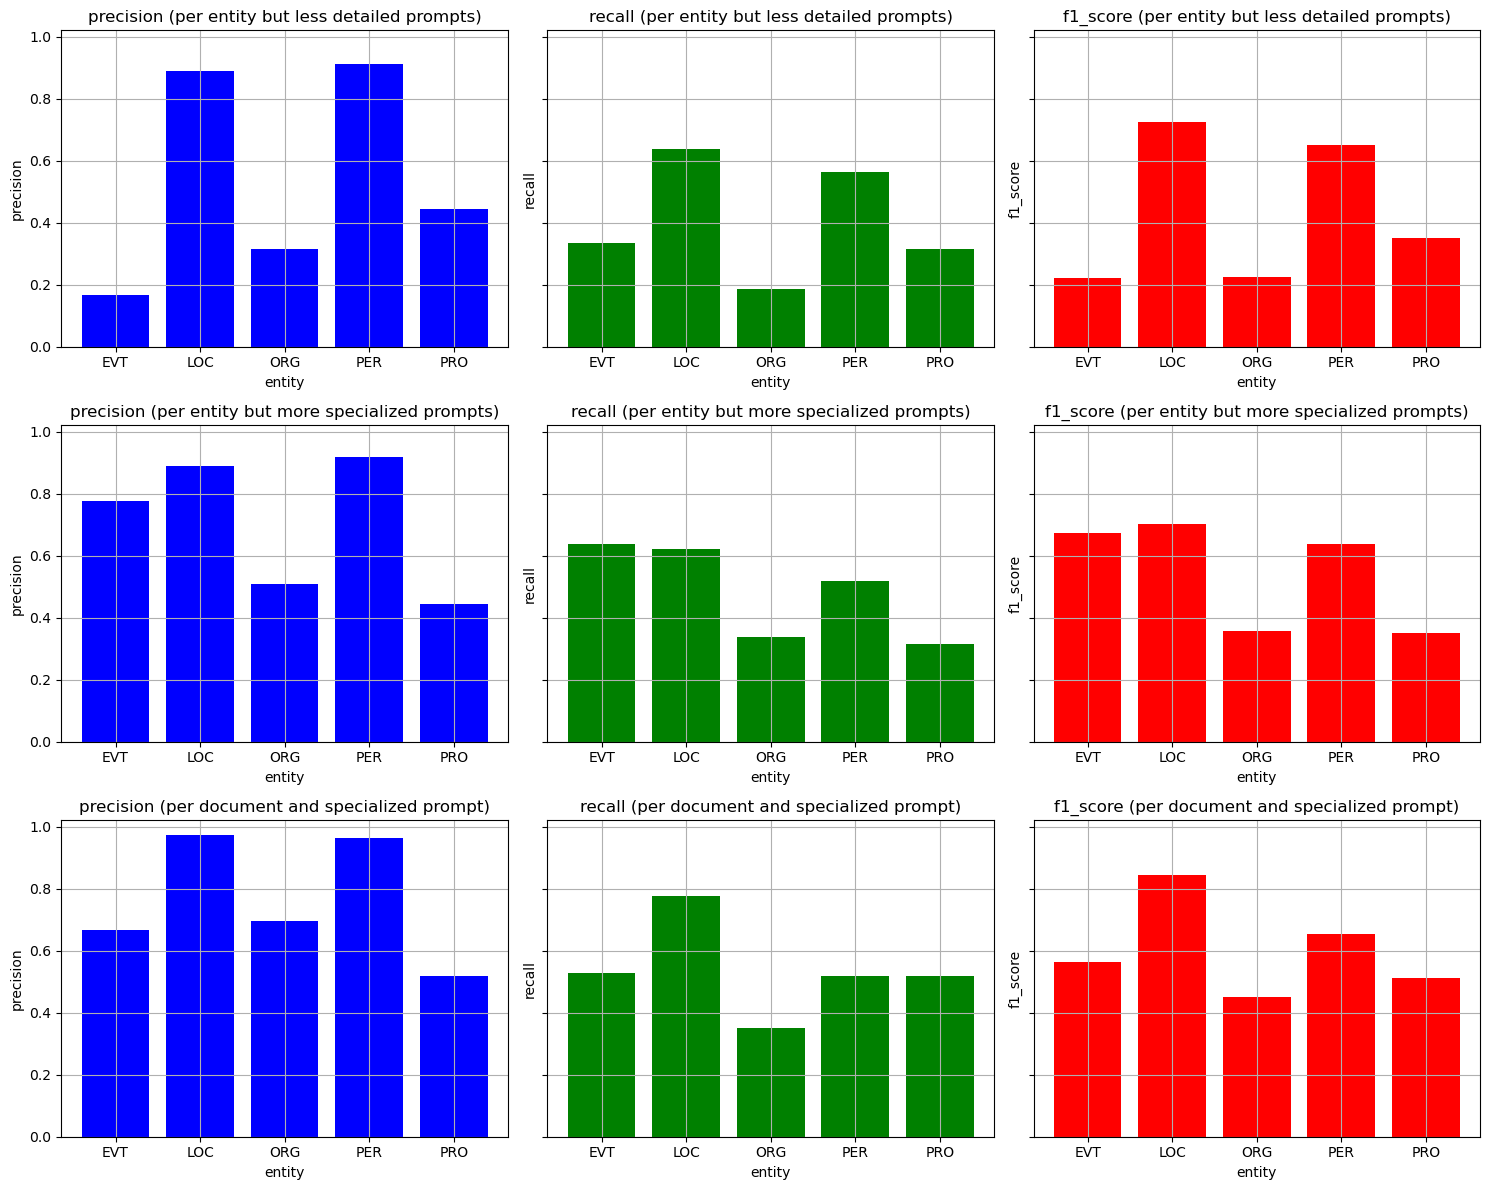

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharey=True)


for i in range(3):
    metrics_df = metrics_by_entity_list[i]
    for j in range(3):
        METRICS = ['precision', 'recall', 'f1_score']
        ROW_TITLE = ['(per entity but less detailed prompts)', '(per entity but more specialized prompts)', '(per document and specialized prompt)']
        COLORS = ['blue', 'green', 'red']

        ax[i, j].bar(metrics_df['entity'], metrics_df[METRICS[j]], color=COLORS[j])

        ax[i, j].set_ylabel(METRICS[j])
        ax[i, j].set_xlabel('entity')
        ax[i, j].set_title(METRICS[j] + ' ' + ROW_TITLE[i])
        ax[i, j].grid()


fig.set_size_inches(15, 12)
fig.tight_layout()
plt.show()

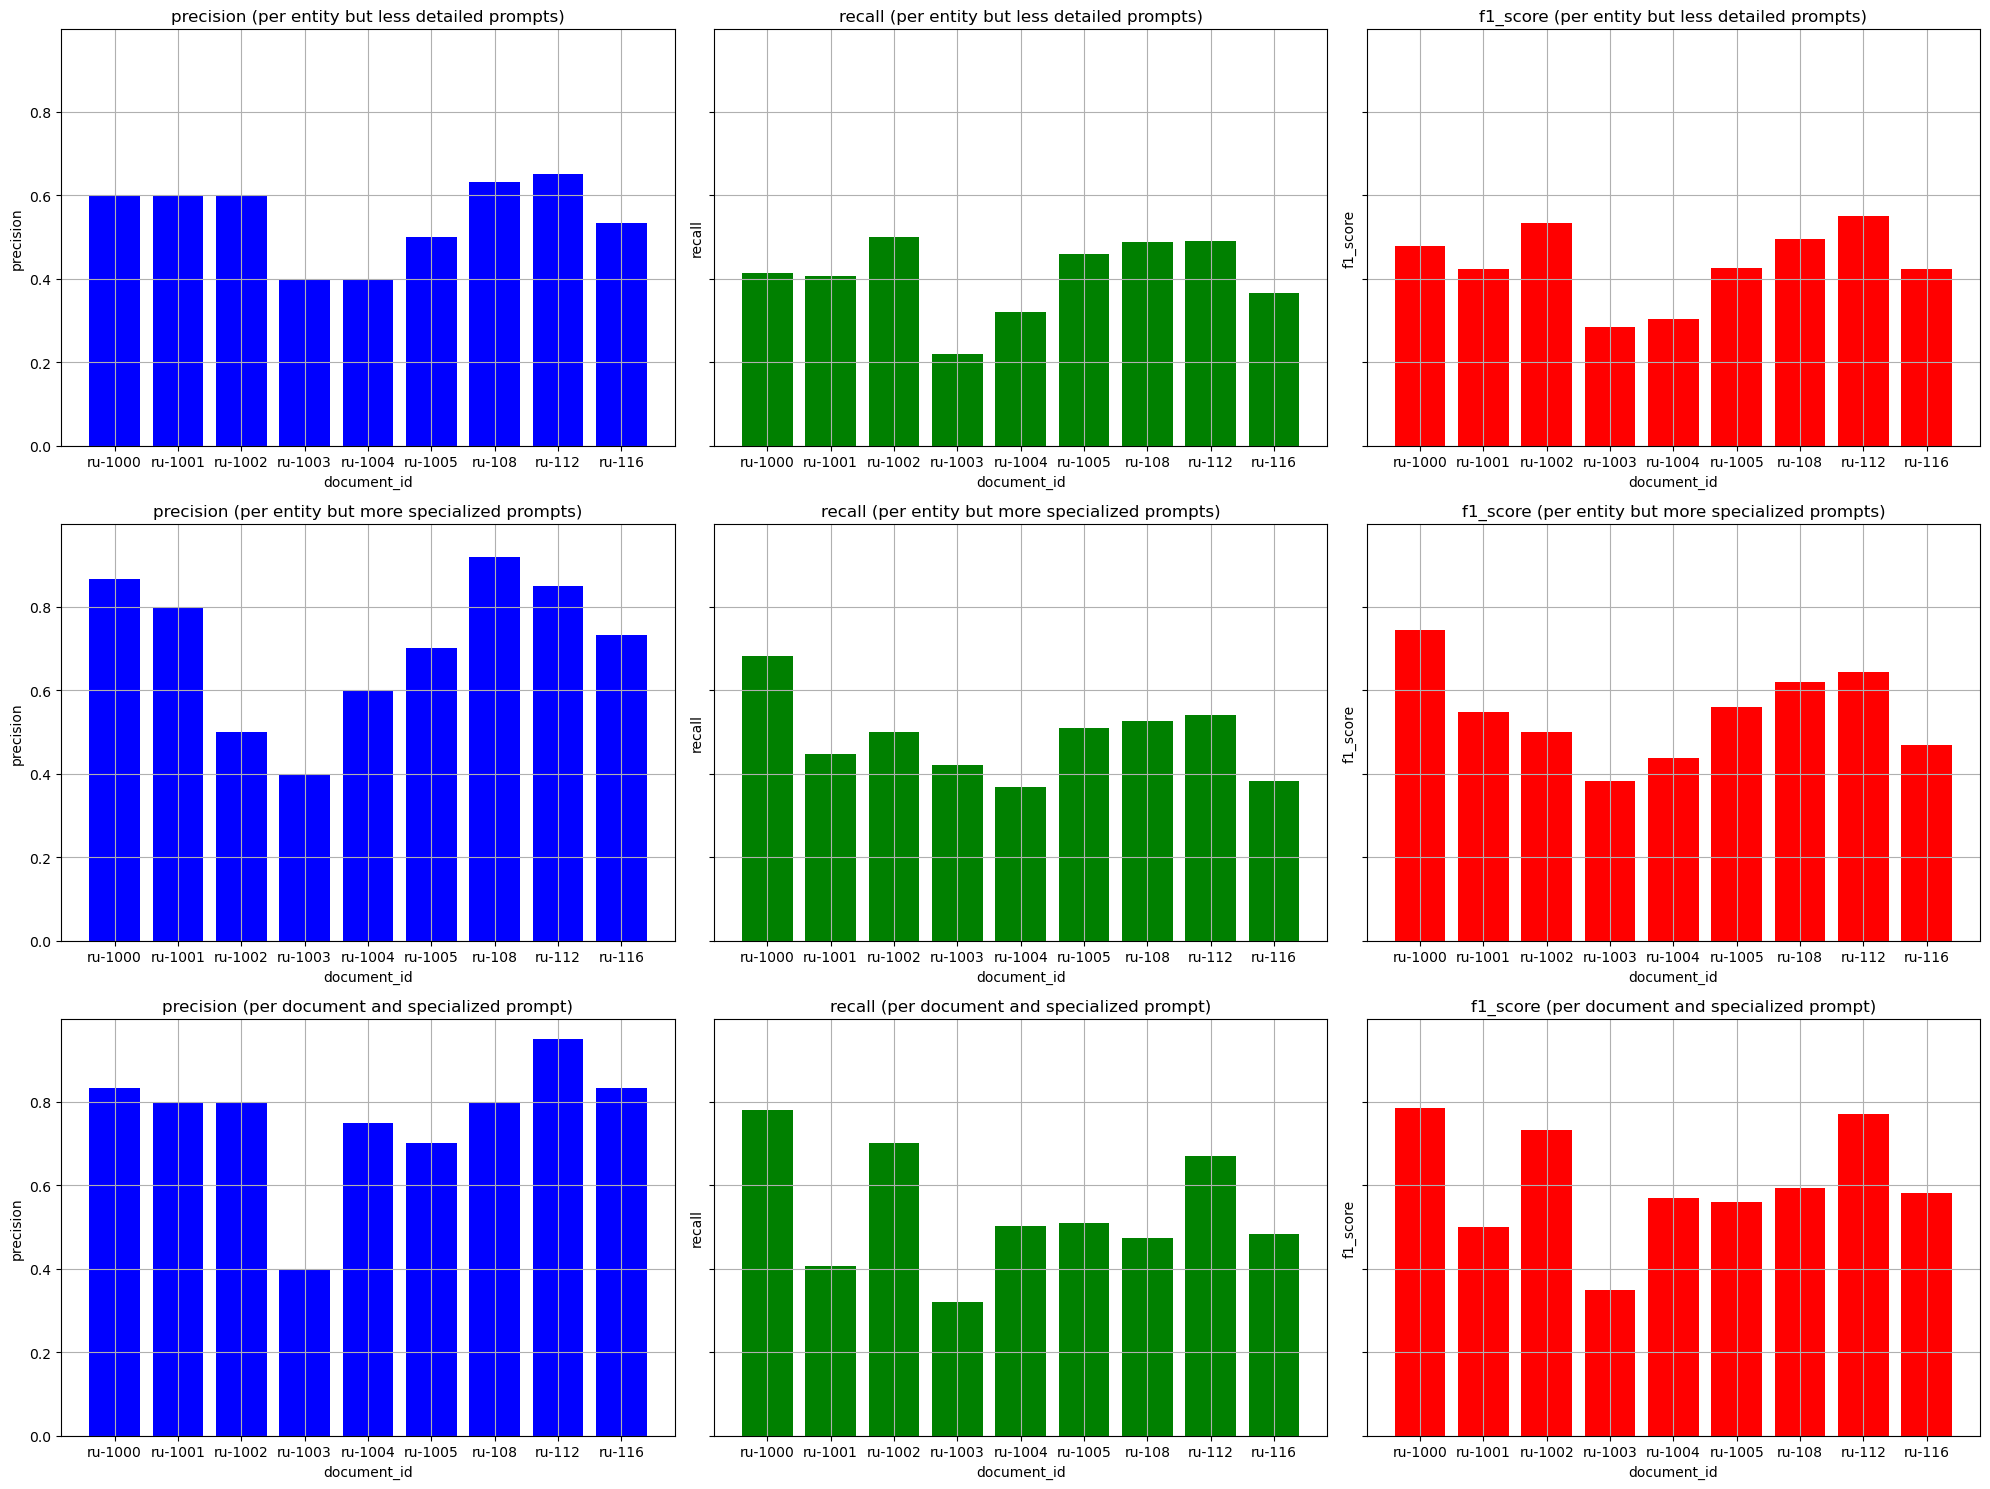

In [17]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(3, 3, sharey=True)

for i in range(3):
    metrics_df = metrics_by_document_list[i]
    for j in range(3):
        METRICS = ['precision', 'recall', 'f1_score']
        ROW_TITLE = ['(per entity but less detailed prompts)', '(per entity but more specialized prompts)', '(per document and specialized prompt)']
        COLORS = ['blue', 'green', 'red']

        ax[i, j].bar(metrics_df['document_id'], metrics_df[METRICS[j]], color=COLORS[j])

        ax[i, j].set_ylabel(METRICS[j])
        ax[i, j].set_xlabel('document_id')
        ax[i, j].set_title(METRICS[j] + ' ' + ROW_TITLE[i])
        ax[i, j].grid()

fig.set_size_inches(20, 15)
fig.tight_layout()
plt.show()

In [18]:
# ИТОГОВОЕ СРАВНЕНИЕ ПОДХОДОВ
for i, title in enumerate(['per entity prompt and not detailed prompts', 'per entity prompt and more detailed prompts', 'per document prompt and detailed prompt']):
    print(title)
    print('precision: ', metrics_by_entity_list[i]['precision'].mean())
    print('recall: ', metrics_by_entity_list[i]['recall'].mean())
    print('f1_score: ', metrics_by_entity_list[i]['f1_score'].mean())
    print()

per entity prompt and not detailed prompts
precision:  0.5460493827160494
recall:  0.407037037037037
f1_score:  0.435095275095275

per entity prompt and more detailed prompts
precision:  0.7077777777777777
recall:  0.4862962962962962
f1_score:  0.545042365042365

per document prompt and detailed prompt
precision:  0.7629629629629628
recall:  0.5385185185185185
f1_score:  0.6049718183051516



### Задание 7

   - Построил графики зависимости метрик от длины документа.
   - Явной зависимости не видно, однако если исключить из рассмотрения документ 'ru-1003' с аномально низкими метриками, то можно выдвинуть предположение о снижении значений метрик с увеличением размера текста.
   - Однако для полного подтверждения (или опровержения) стоило бы рассмотреть больше документов (в частности, взять документы с большей разницей в размере, так как все рассмотренные документы находятся в небольшом промежутке 60-180 слов)

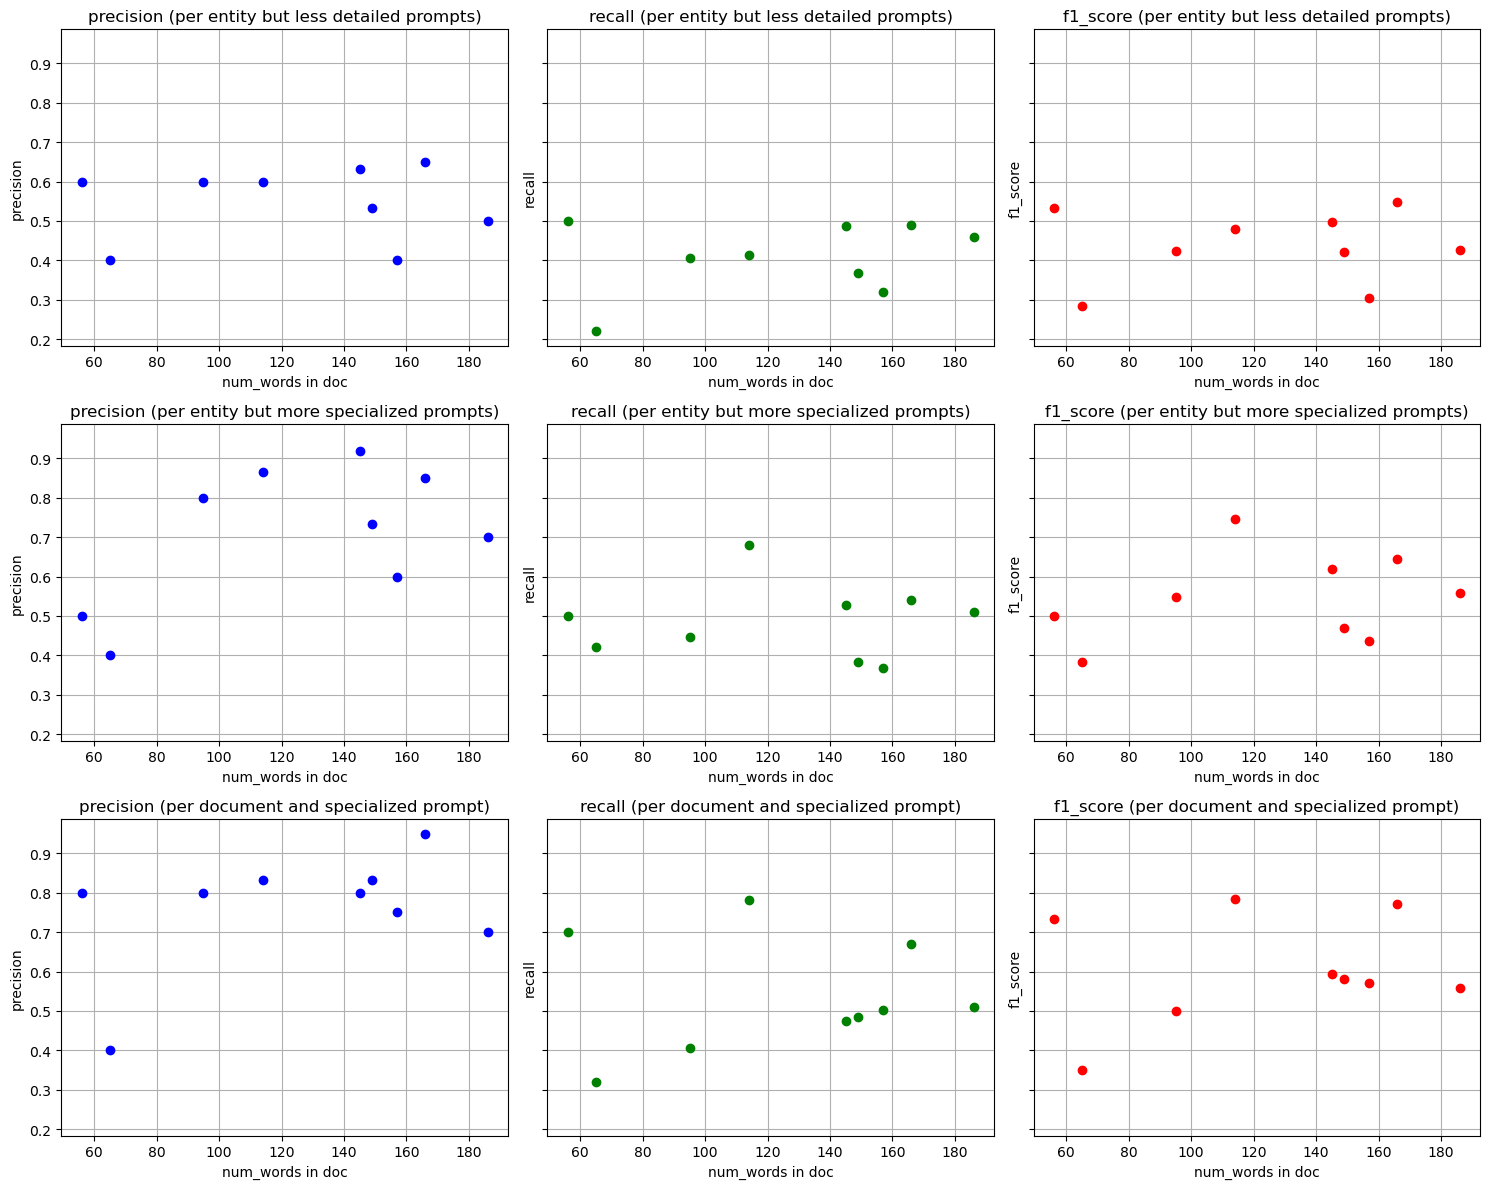

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharey=True)

for i in range(3):
    metrics_df = metrics_by_document_list[i]
    for j in range(3):
        METRICS = ['precision', 'recall', 'f1_score']
        ROW_TITLE = ['(per entity but less detailed prompts)', '(per entity but more specialized prompts)', '(per document and specialized prompt)']
        COLORS = ['blue', 'green', 'red']

        ax[i, j].plot(metrics_df['document_len'], metrics_df[METRICS[j]], 'o', color=COLORS[j])

        ax[i, j].set_ylabel(METRICS[j])
        ax[i, j].set_xlabel('num_words in doc')
        ax[i, j].set_title(METRICS[j] + ' ' + ROW_TITLE[i])
        ax[i, j].grid()

fig.set_size_inches(15, 12)
fig.tight_layout()
plt.show()

### Задание 8

   - Если рассматривать итоговую модель с лучшим качеством (3 ряд на графиках), то она чаще всего ошибается в различении ORG и PRO entities. Например, The Sunday Telegraph - PRO, а Associated Press - ORG (модель же определяет и то, и другое в категорию PRO). Чтобы это устранить, можно попробовать добавить примеры правильного различения внутрь промпта.
   - Также модель часто выводит сущности не в том виде, в котором они были в тексте (к примеру, если в тексте встречается "Евросоюз", то модель может заменить его в ответе на "ЕС"). Для исправления подобного поведения можно попробовать `chain-of-thought` метод, то есть попросить модель объяснять получение ответов, дав ей в промпте пример текста с ответами и объяснением, как именно они были получены. 
   - Из графиков видно, что модель имеет в среднем существенно больший `precision`, чем `recall`, то есть модель дает довольно много верных ответов, но помимо них много и ложноположительных. Можно попробовать как-то это использовать для повышения качества. Например, попросить модель указывать только те ответы, в которых она наиболее уверена. Или указать больше отрицательных примеров, то есть дать пример текста и сообщить, какие слова из него точно не стоит указывать в качестве entity.

### Задание 9

   - Очень интересное задание: есть пространство для рассмотрения различных подходов и исследования задачи для подбора оптимального промпта.
   - Научился лучше составлять промпты для LLM под конкретную задачу, поработал с GigaChat.
   - Получил опыт в решении задачи NER с помощью LLM методом промпт-инжиниринга.